In [33]:
from mdss.ScoringFunctions.Bernoulli import Bernoulli
from mdss.ScoringFunctions.Poisson import Poisson
from mdss.MDSS import MDSS

import numpy as np
import pandas as pd
from pandas.api.types import is_numeric_dtype

import warnings

warnings.filterwarnings('ignore')

In [34]:
data = pd.read_csv('../project2_data_21_04_23.csv').drop(columns = 
       ['Unnamed: 0','study_id']).fillna(-999)
# target_cols = ['htn_jnc7_qc', 'diabetes_status_c_qc', 'ckd_c_qc', 'cadiovascular_current']
# target_cols = ['htn_jnc7_qc', 'diabetes_status_c_qc']
target_cols = ['diabetes_status_c_qc']

In [35]:
numeric_columns = [col for col in data.columns \
                     if (is_numeric_dtype(data[col])) \
                     & (col not in target_cols) \
                     & (data[col].nunique() > 10)]

### Agincourt site scanning for diabetes

In [36]:
site_id = 1 # 1 - Agincourt, 3 - Nairobi

# Choose the relevant site and age group
dff = data[(data['site'] == site_id) & (data['age'] <= 60) & (data['age'] >= 40)].fillna(-999)

print('Original size: ', dff.shape)
dff = dff[(dff[target_cols] != -999).sum(axis = 1) == len(target_cols)].copy()
print('Size after removing records with missing targets: ', dff.shape)

Original size:  (1465, 25)
Size after removing records with missing targets:  (1465, 25)


In [37]:
target_cols = ['diabetes_status_c_qc']
# target_cols = ['htn_jnc7_qc', 'diabetes_status_c_qc']
target_col = 'diab_hyp'
# target = 'MorbidityCount'

# defining the target column to be a column where the sum of the target values >= 2
# dff[target_col] = (dff[target_cols] == 1).sum(axis = 1) == 2 # *****CHECK********
dff[target_col] = (dff[target_cols] == 1) # *******CHECK**********

# defining the expectations as mean of the target
dff['expectation'] = dff[target_col].mean()

In [38]:
# Defining the search space to be all the features except site, study_id, 
# and our created target_col and expectations columns

search_space = [col for col in dff.columns \
                if col not in \
                [target_col, 'site', 'study_id', 'expectation', \
                'htn_jnc7_qc', 'diabetes_status_c_qc', 'ckd_c_qc', 'cadiovascular_current']]

In [39]:
def get_str(x):
    # This function turns a pandas bin to a meaningful string
    s = str(round(x.left, 2)) + ' - ' + str(round(x.right,2))
    return s

def custom_qcut(ser, contiguous = True):
    # Get the rows that are actual numbers
    sub_ser = ser[(ser != -111) \
                     & (ser != -222) \
                     & (ser != -555) \
                     & (ser != -999)]
    
    if contiguous:
        # if contiguous, treat all the special numbers the same
        ser = ser.replace(-111 , -999)
        ser = ser.replace(-222 , -999)
        ser = ser.replace(-555 , -999)

    # Bin the actual numbers into 10 bins for scanning
    sub_ser = pd.qcut(sub_ser, 10, duplicates='drop')
    sub_ser = sub_ser.apply(get_str).astype(str)
    ser[list(sub_ser.index)] = sub_ser
    return ser


In [40]:
contiguous = {}
dff_2 = dff.copy()

# Create a new dataframe with the numeric columns bins     
for col in numeric_columns:
    if col in search_space:
        dff_2[col] = custom_qcut(dff_2[col].copy())
        
        bins = list(dff_2[col].unique())
        
        if -999 in bins:
            bins.remove(-999)
        
        bins = sorted(bins, key=lambda x : float(x.split(' - ')[0]))
        
        contiguous[col] = bins

In [41]:
def compress_contiguous(subset, contiguous):
    # Shorten a contiguous list e.g [0-9, 10-19] is converted to [0 - 19] 
    new = {}
    
    for col in subset:
        if col in contiguous:
            if isinstance(subset[col][0], (float,int)):
                new[col] = [str(c) for c in subset[col]]
                continue
            i = -1 if isinstance(subset[col][-1], str) else -2
            new[col] = [subset[col][0].split(' - ')[0] + ' - ' + subset[col][i].split(' - ')[-1]]
            new[col] = new[col] if i == -1 else new[col] + [str(subset[col][-1])]
        else:
            new[col] = [str(c) for c in subset[col]]
    return new

def translate_subset_to_rule(subset):
    # Print the subset as a rule for easier understanding
    desc = ''
    for key, value in subset.items():
        # desc += key + ' = {' + ' OR '.join(value) + '} AND' + '\n'
        desc += key + '{' + ' OR '.join(value) + '} AND' + ' '

    return desc[:-5].replace('_',' ').replace('{', '[').replace('}', ']')

def count_conditions(subset):
    # Split the string by 'AND' and 'OR'
    conditions = subset.replace("AND", "OR").split("OR")
    
    # Count the number of conditions
    condition_count = len(conditions)
    
    return condition_count

In [57]:
# %%time
# Scan in the positive direction using defined penalties and num iters

scoring_function = Bernoulli(direction='negative')
scanner = MDSS(scoring_function)
# Define a list of penalty values to loop through
penalty_values = [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]
# penalty_values = [1.0, 1.5, 2, 2.5]
num_iters = 10
# Initialize empty lists to store results
subset_results = []
subset_results1 = []
score_results = []
size_results = []
odds_results = []
count_results = []
dataframes = {}

# Loop through each penalty value
for penalty in penalty_values:
    # Perform the scan with the current penalty value
    subset, score = scanner.scan(dff_2[search_space], dff_2[target_col], dff_2['expectation'], cpu=0.95,
                                 penalty=penalty, num_iters=num_iters, contiguous=contiguous.copy())
    
    to_choose = dff_2[subset.keys()].isin(subset).all(axis=1)
    temp_df = dff_2.loc[to_choose]

    # Store each DataFrame in the dictionary with a unique key
    dataframes[f'df_{penalty}'] = temp_df

    size = len(temp_df)
    observed_income = np.round(temp_df[target_col].mean(), 3)
    positive_class_count = temp_df[target_col].sum()

    group_obs = temp_df[target_col].mean()
    group_prob = temp_df['expectation'].mean()
    odds_mul = (group_obs / (1 - group_obs)) / (group_prob /(1 - group_prob))
    counting = count_conditions(translate_subset_to_rule(compress_contiguous(subset, contiguous)))
    
    # Append the results to the respective lists

    # subset_results.append(subset)
    score_results.append(np.round(score, 3))
    size_results.append(size)
    odds_results.append(np.round(odds_mul, 3))
    subset_results1.append(translate_subset_to_rule(compress_contiguous(subset, contiguous)))
    count_results.append(counting)


# # Display the results for each penalty value
# for i, penalty in enumerate(penalty_values):
#     print(f"Penalty = {penalty}: Subset = {subset_results[i]}, Score = {score_results[i]}")

# Display the results for each penalty value
for i, penalty in enumerate(penalty_values):
    print(f"Penalty = {penalty}: Subset = {subset_results1[i]}, \nLiteralsNumber = {count_results[i]}, \nSize = {size_results[i]}, Odds = {odds_results[i]}, Score = {score_results[i]}")

Penalty = 0.5: Subset = triglycerides qc[0.25 - 1.49 OR -999.0] AND waist circumference qc[510.0 - 950.0] AND mvpa cat c[1.0] AND waist hip r c qc[0.59 - 0.9] AND partnership status c qc[0 OR 1] AND highest level of education qc[0 OR 1 OR 2], 
LiteralsNumber = 10, 
Size = 379, Odds = 0.0, Score = 20.41
Penalty = 1: Subset = friedewald ldl c c qc[1.36 - 7.6] AND triglycerides qc[0.25 - 1.49] AND partnership status c qc[0 OR 1] AND mvpa cat c[1.0] AND bmi c qc[14.53 - 30.08] AND waist hip r c qc[0.59 - 0.88], 
LiteralsNumber = 7, 
Size = 277, Odds = 0.0, Score = 11.571
Penalty = 1.5: Subset = triglycerides qc[0.54 - 1.49] AND subcutaneous fat qc[0.25 - 1.45 OR -999.0] AND waist hip r c qc[0.59 - 0.92], 
LiteralsNumber = 4, 
Size = 341, Odds = 0.0, Score = 16.862
Penalty = 2: Subset = mvpa cat c[1.0] AND waist circumference qc[510.0 - 780.0], 
LiteralsNumber = 2, 
Size = 258, Odds = 0.0, Score = 13.297
Penalty = 2.5: Subset = mvpa cat c[1.0] AND waist circumference qc[510.0 - 780.0], 
Lit

In [58]:
results_df = pd.DataFrame({
    'Penalty': penalty_values,
    'No of literals': count_results,
    'Subset': subset_results1,
    'Size': size_results,
    'Odds': odds_results,
    'Score': score_results
})

# Display the DataFrame
results_df

,Penalty,No of literals,Subset,Size,Odds,Score
0,0.5,10,triglycerides qc[0.25 - 1.49 OR -999.0] AND wa...,379,0.000,20.410
1,1.0,7,friedewald ldl c c qc[1.36 - 7.6] AND triglyce...,277,0.000,11.571
2,1.5,4,triglycerides qc[0.54 - 1.49] AND subcutaneous...,341,0.000,16.862
3,2.0,2,mvpa cat c[1.0] AND waist circumference qc[510...,258,0.000,13.297
4,2.5,2,mvpa cat c[1.0] AND waist circumference qc[510...,258,0.000,12.297
5,3.0,2,mvpa cat c[1.0] AND waist circumference qc[510...,258,0.000,11.297
6,3.5,1,waist circumference qc[510.0 - 780.0],314,0.092,10.783
7,4.0,1,waist circumference qc[510.0 - 780.0],314,0.092,10.283
8,4.5,1,waist circumference qc[510.0 - 780.0],314,0.092,9.783
9,5.0,1,waist circumference qc[510.0 - 780.0],314,0.092,9.283


In [56]:
results_df.to_csv('results_df_negative.csv', index=False)

In [52]:
# Identify unique observations from the datasets
unique_ids = np.unique(np.concatenate([dataframes['df_2.5'].index, dataframes['df_3.5'].index, dataframes['df_4'].index,]))

# Create a DataFrame with values of 1 in the baseline column and 0 or 1 in the other columns
final_df = pd.DataFrame(index=unique_ids, columns=['4_literals', '3_literals', '1_literal'])

# Set values based on the presence of IDs in the datasets
# final_df['Baseline'] = 1
final_df['4_literals'] = final_df.index.isin(dataframes['df_2.5'].index).astype(int)
final_df['3_literals'] = final_df.index.isin(dataframes['df_3.5'].index).astype(int)
final_df['1_literal'] = final_df.index.isin(dataframes['df_4'].index).astype(int)

# Display the final DataFrame
print(final_df)

      4_literals  3_literals  1_literal
378            1           1          1
379            0           0          1
388            1           0          1
389            0           0          1
397            1           0          0
...          ...         ...        ...
4394           0           0          1
4422           1           0          0
4471           0           0          1
4472           1           0          0
4477           1           0          0

[242 rows x 3 columns]


In [53]:
# get coordinates where event occurs (value=1)
row_paths, col_paths = np.where(final_df.eq(1))
mask = pd.DataFrame(data= {'rows':row_paths, 'cols':col_paths})

# aggregate by row to get application's path
agg_mask = mask.groupby('rows').apply(lambda x: [x for x in x.cols])
agg_mask.tail()

rows
237    [2]
238    [0]
239    [2]
240    [0]
241    [0]
dtype: object

In [54]:
all_events = []

# get pair of source and target
for row in agg_mask:
    for index in range(len(row)-1):
        all_events.append([row[index], row[index+1]])
        
# create df for aggregation        
sankey_ST = pd.DataFrame(data=all_events)
sankey_ST = sankey_ST.rename(columns={0:'source', 1:'target'})
sankey_ST = sankey_ST.value_counts().reset_index()
sankey_ST = sankey_ST.rename(columns={0:'value'})

sankey_ST.head()

,source,target,value
0,1,2,48
1,0,2,27
2,0,1,24


In [55]:
import plotly.graph_objects as go
fig = go.Figure(data=[go.Sankey(
    node = dict(
        pad = 15,
        thickness = 20,
        label = [f'{x}: {final_df[x].sum()}' for x in final_df.columns]
    ),
    link=dict(
        source = sankey_ST['source'],
        target = sankey_ST['target'],
        value = sankey_ST['value']
    ),
)])


fig.update_layout(title_text='Flow of individuals in different literals', font_size=10)
fig.update_traces(textfont_size=12)
fig.show()

In [49]:
ang1_up = final_df.mask(final_df == 1, np.nan)

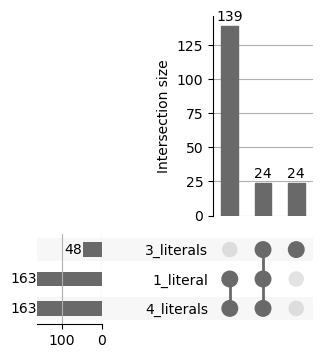

In [50]:
import upsetplot
from upsetplot import UpSet, plot, from_indicators
from upsetplot import from_contents
# angpain.values

# ang1 = angpain.set_index(angpain.pain_qc == True).set_index(angpain.pain2_qc == 1, append=True).set_index(angpain.pain_location_12_qc == 1, append=True)
# UpSet(ang1)
UpSet(from_indicators(pd.isna, data=ang1_up.iloc[:,0:]), show_counts=True, sort_by= 'cardinality', max_subset_size=1000, facecolor='dimgrey')
# upsetplot.query(ang1)
# upset = UpSet(angpain,element_size=32)